<a href="https://colab.research.google.com/github/Sammm21/ML/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NLP Deep Dive: RNNs**

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 8.9MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 1.2MB 42.1MB/s 
     |████████████████████████████████| 194kB 26.5MB/s 
     |████████████████████████████████| 61kB 10.2MB/s 
     |████████████████████████████████| 61kB 10.5MB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *
from IPython.display import display,HTML

What we call a language model is a model that has been trained to guess what the next word in a text is (having read the ones before). This kind of task is called self-supervised learning: we do not need to give labels to our model, just feed it lots and lots of texts. It has a process to automatically get labels from the data, and this task isn't trivial: to properly guess the next word in a sentence, the model will have to develop an understanding of the English (or other) language. Self-supervised learning can also be used in other domains; for instance, see "Self-Supervised Learning and Computer Vision" for an introduction to vision applications. Self-supervised learning is not usually used for the model that is trained directly, but instead is used for pretraining a model used for transfer learning.

**Self-supervised learning: Training a model using labels that are embedded in the independent variable, rather than requiring external labels. For instance, training a model to predict the next word in a text**

The language model we used in <<chapter_intro>> to classify IMDb reviews was pretrained on Wikipedia. We got great results by directly fine-tuning this language model to a movie review classifier, but with one extra step, we can do even better. The Wikipedia English is slightly different from the IMDb English, so instead of jumping directly to the classifier, we could fine-tune our pretrained language model to the IMDb corpus and then use *that* as the base for our classifier.

Even if our language model knows the basics of the language we are using in the task (e.g., our pretrained model is in English), it helps to get used to the style of the corpus we are targeting. It may be more informal language, or more technical, with new words to learn or different ways of composing sentences. In the case of the IMDb dataset, there will be lots of names of movie directors and actors, and often a less formal style of language than that seen in Wikipedia.

One reason, of course, is that it is helpful to understand the foundations of the models that you are using. But there is another very practical reason, which is that you get even better results if you fine-tune the (sequence-based) language model prior to fine-tuning the classification model. For instance, for the IMDb sentiment analysis task, the dataset includes 50,000 additional movie reviews that do not have any positive or negative labels attached. Since there are 25,000 labeled reviews in the training set and 25,000 in the validation set, that makes 100,000 movie reviews altogether. We can use all of these reviews to fine-tune the pretrained language model, which was trained only on Wikipedia articles; this will result in a language model that is particularly good at predicting the next word of a movie review.

This is known as the Universal Language Model Fine-tuning (ULMFit) approach. The [paper](https://arxiv.org/abs/1801.06146) showed that this extra stage of fine-tuning of the language model, prior to transfer learning to a classification task, resulted in significantly better predictions. Using this approach, we have three stages for transfer learning in NLP, as summarized in <<ulmfit_process>>.

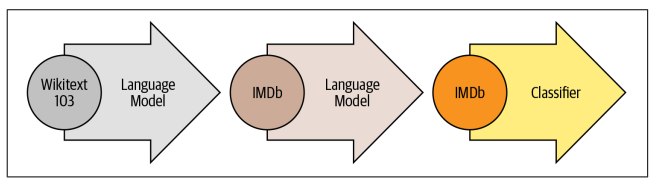

We'll now explore how to apply a neural network to this language modeling problem, using the concepts introduced in the last two chapters. But before reading further, pause and think about how *you* would approach this.

## Text Preprocessing

HOW DO WE PREDICT THE NEXT WORD IN A SENTENCE USING A NEURAL NET?

We've already seen how categorical variables can be used as independent variables for a neural network. The approach we took for a single categorical variable was to:

1. Make a list of all possible levels of that categorical variable (we'll call this list the *vocab*).
1. Replace each level with its index in the vocab.
1. Create an embedding matrix for this containing a row for each level (i.e., for each item of the vocab).
1. Use this embedding matrix as the first layer of a neural network. (A dedicated embedding matrix can take as inputs the raw vocab indexes created in step 2; this is equivalent to but faster and more efficient than a matrix that takes as input one-hot-encoded vectors representing the indexes.)

**We can do nearly the same thing with text! What is new is the idea of a sequence. First we concatenate all of the documents in our dataset into one big long string and split it into words, giving us a very long list of words (or "tokens"). Our independent variable will be the sequence of words starting with the first word in our very long list and ending with the second to last, and our dependent variable will be the sequence of words starting with the second word and ending with the last word.** 

Our vocab will consist of a mix of common words that are already in the vocabulary of our pretrained model and new words specific to our corpus (cinematographic terms or actors names, for instance). Our embedding matrix will be built accordingly: for words that are in the vocabulary of our pretrained model, we will take the corresponding row in the embedding matrix of the pretrained model; but for new words we won't have anything, so we will just initialize the corresponding row with a random vector.

Each of the steps necessary to create a language model has jargon associated with it from the world of natural language processing:


- Tokenization:: Convert the text into a list of words (or characters, or substrings, depending on the granularity of your model)
- Numericalization:: Make a list of all of the unique words that appear (the vocab), and convert each word into a number, by looking up its index in the vocab
- Language model data loader creation:: fastai provides an `LMDataLoader` class which automatically handles creating a dependent variable that is offset from the independent variable by one token. It also handles some important details, such as how to shuffle the training data in such a way that the dependent and independent variables maintain their structure as required
- Language model creation:: We need a special kind of model that does something we haven't seen before: handles input lists which could be arbitrarily big or small. There are a number of ways to do this; in this chapter we will be using a *recurrent neural network* (RNN). We will get to the details of these RNNs in the <<chapter_nlp_dive>>, but for now, you can think of it as just another deep neural network.

Let's take a look at how each step works in detail.

### Tokenization

When we said "convert the text into a list of words," we left out a lot of details. For instance, what do we do with punctuation? How do we deal with a word like "don't"? Is it one word, or two? What about long medical or chemical words? Should they be split into their separate pieces of meaning? How about hyphenated words? What about languages like German and Polish where we can create really long words from many, many pieces? What about languages like Japanese and Chinese that don't use bases at all, and don't really have a well-defined idea of *word*?

Because there is no one correct answer to these questions, there is no one approach to tokenization. There are three main approaches:

- Word-based:: Split a sentence on spaces, as well as applying language-specific rules to try to separate parts of meaning even when there are no spaces (such as turning "don't" into "do n't"). Generally, punctuation marks are also split into separate tokens.
- Subword based:: Split words into smaller parts, based on the most commonly occurring substrings. For instance, "occasion" might be tokenized as "o c ca sion."
- Character-based:: Split a sentence into its individual characters.

We'll be looking at word and subword tokenization here, and we'll leave character-based tokenization for you to implement in the questionnaire at the end of this chapter.

### Word Tokenization with fastai

Let's try word tokenization with the IMDb dataset:

In [3]:
from fastai.text.all import *
path = untar_data(URLs.IMDB)

Grab the text files with `get_text_files` which works a lot like `get_image_files`
And we pass folders to restrict the search to a particular list of subfolders:

In [4]:
files = get_text_files(path, folders = ['train', 'test', 'unsup'])

In [5]:
get_text_files??

In [6]:
len(files), type(files)

(100000, fastcore.foundation.L)

`txt` is a small review of what we intend to tokenize:

In [7]:
txt = files[0].open().read(); txt[:75]

"My Young Auntie is unique in a lot of ways. First this is Hui Ya-Hung's (Ka"

In [8]:
len(txt)

1202

Rather than directly using `SpacyTokenizer`, however, we'll use `WordTokenizer`, since that will always point to fastai's current default word tokenizer (which may not necessarily be spaCy, depending when you're reading this).

Let's try it out. We'll use fastai's `coll_repr(collection, n)` function to display the results. This displays the first *`n`* items of *`collection`*, along with the full size—it's what `L` uses by default. **Note that fastai's tokenizers take a collection of documents to tokenize, so we have to wrap `txt` in a list:**

In [9]:
spacy = WordTokenizer()
toks = first(spacy([txt]))
print(coll_repr(toks, 30))

(#254) ['My','Young','Auntie','is','unique','in','a','lot','of','ways','.','First','this','is','Hui','Ya','-','Hung',"'s",'(','Kara','Hui',')','first','action','film','.','Second','She','was'...]


So we have 254 tokens and the first 31 are printed above

As we can see our tokenizer has just seperated out the words and the punctuation. But also it has split Hung's into "Hung" and "s"- which makes sense since they're different words.

In [10]:
first(spacy(['The U.S. dollar $1 is $1.00.']))

(#9) ['The','U.S.','dollar','$','1','is','$','1.00','.']

What does `first` do:



```
first??
```



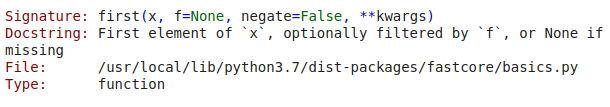

We can add some additional functionality to the tokenization process with the `Tokenizer` class so we pass our `WordTokenizer()` to it:

In [11]:
tkn = Tokenizer(spacy)
print(coll_repr(tkn(txt), 3))

(#306) ['xxbos','xxmaj','my'...]


In [12]:
print(coll_repr(tkn(txt), 31))

(#306) ['xxbos','xxmaj','my','xxmaj','young','xxmaj','auntie','is','unique','in','a','lot','of','ways','.','xxmaj','first','this','is','xxmaj','hui','ya','-','hung',"'s",'(','kara','xxmaj','hui',')','first'...]


Notice that there are now some tokens that start with the characters "xx", which is not a common word prefix in English. These are *special tokens*.

For example, the first item in the list, `xxbos`, is a special token that indicates the start of a new text ("BOS" is a standard NLP acronym that means "beginning of stream"). By recognizing this start token, the model will be able to learn it needs to "forget" what was said previously and focus on upcoming words.

These special tokens don't come from spaCy directly. They are there because fastai adds them by default, by applying a number of rules when processing text. These rules are designed to make it easier for a model to recognize the important parts of a sentence. In a sense, we are translating the original English language sequence into a simplified tokenized language—a language that is designed to be easy for a model to learn.

For instance, the rules will replace a sequence of four exclamation points with a special *repeated character* token, followed by the number four, and then a single exclamation point. In this way, the model's embedding matrix can encode information about general concepts such as repeated punctuation rather than requiring a separate token for every number of repetitions of every punctuation mark. Similarly, a capitalized word will be replaced with a special capitalization token, followed by the lowercase version of the word. This way, the embedding matrix only needs the lowercase versions of the words, saving compute and memory resources, but can still learn the concept of capitalization.

Here are some of the main special tokens you'll see:

- `xxbos`:: Indicates the beginning of a text (here, a review)
- `xxmaj`:: Indicates the next word begins with a capital (since we lowercased everything)
- `xxunk`:: Indicates the word is unknown

To see the rules that were used, you can check the default rules:

In [13]:
defaults.text_proc_rules

[<function fastai.text.core.fix_html>,
 <function fastai.text.core.replace_rep>,
 <function fastai.text.core.replace_wrep>,
 <function fastai.text.core.spec_add_spaces>,
 <function fastai.text.core.rm_useless_spaces>,
 <function fastai.text.core.replace_all_caps>,
 <function fastai.text.core.replace_maj>,
 <function fastai.text.core.lowercase>]

In [14]:
??replace_rep

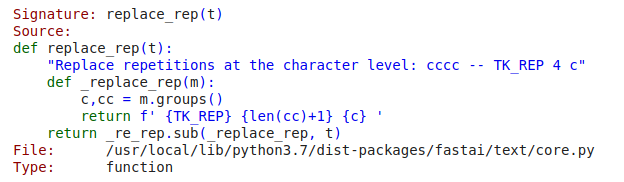



Here is a brief summary of what each does:

- `fix_html`:: Replaces special HTML characters with a readable version (IMDb reviews have quite a few of these)
- `replace_rep`:: Replaces any character repeated three times or more with a special token for repetition (`xxrep`), the number of times it's repeated, then the character
- `replace_wrep`:: Replaces any word repeated three times or more with a special token for word repetition (`xxwrep`), the number of times it's repeated, then the word
- `spec_add_spaces`:: Adds spaces around / and #
- `rm_useless_spaces`:: Removes all repetitions of the space character
- `replace_all_caps`:: Lowercases a word written in all caps and adds a special token for all caps (`xxup`) in front of it
- `replace_maj`:: Lowercases a capitalized word and adds a special token for capitalized (`xxmaj`) in front of it
- `lowercase`:: Lowercases all text and adds a special token at the beginning (`xxbos`) and/or the end (`xxeos`)

### **Subword Tokenization**

Some languages don't have a concept of a word (like chinese) others smash a bunch of words together (like hungarian and swedish).These cases aren't going to work well with  tokenizers since tokenization relies on the assumption that spaces provide a useful seperation of components of meaning in a sentence.

To handle these cases we can use subword tokenization. This proceeds in two steps:

1. Analyze a corpus of documents to find the most commonly occuring groups of letters. These become the vocab.
2. Tokenize the corpus using this vocab of *subword* units. 

Let's look at an example. For our corpus, we'll use the first 2000 movie reviews:

In [15]:
txts = L(o.open().read() for o in files[:2000])

After instantiating our tokenizer, passing in the size of the vocab we want to create, we need to "train" it. That is we need to have it read our documents, and find the common sequences of characters, to create the vocab. This is done with `setup`.

In [16]:
def subword(sz):
  sp = SubwordTokenizer(vocab_sz=sz)
  sp.setup(txts)
  return ' '.join(first(sp([txt]))[:40])

When using fastai's subword tokenizer, the special character `▁` represents a space character in the original text.



In [17]:
subword(1000)

"▁M y ▁You ng ▁A unt ie ▁is ▁un i que ▁in ▁a ▁lot ▁of ▁way s . ▁F ir st ▁this ▁is ▁H u i ▁ Y a - H u ng ' s ▁( K ar a ▁H"

If we use a smaller vocab, then each token will represent fewer characters, and it will take more tokens to represent a sentence:

In [18]:
subword(200)

'▁M y ▁ Y o un g ▁A un t i e ▁is ▁ un i q u e ▁in ▁a ▁ l o t ▁of ▁ w a y s . ▁ F ir st ▁this ▁is ▁ H'

On the other hand, if we use a larger vocab, then most common English words will end up in the vocab themselves, and we will not need as many to represent a sentence:

In [19]:
subword(20000)

"▁My ▁Young ▁Aunt ie ▁is ▁unique ▁in ▁a ▁lot ▁of ▁ways . ▁First ▁this ▁is ▁Hui ▁Ya - Hung ' s ▁( Kara ▁Hui ) ▁first ▁action ▁film . ▁Second ▁She ▁was ▁actually ▁doing ▁the ▁fight ▁scenes ▁after ▁hav ing"

Picking a subword vocab size represents a compromise: a larger vocab means fewer tokens per sentence, which means faster training, less memory, and less state for the model to member; but on the downside, it means larger embedding matrices, which require more data to learn. 

Overall though, subword tokenization provides a way to easily scale between character tokenization (i.e. use a small subword vocab) and work tokenization (i.e. use a large subword vocab), and handles every human language without needing language-specific algorithms to be developed. **It can even handle other "languages" such as genomic sequences or MIDI music notation!** For this reason it has become the most common tokenization approach at the time!

Once our text has been split into tokens we need to numericalize it B!

### **Numericalization**

Numericalization is the process of mapping tokens to integers. It's basically identical to the steps necessary to create a `Category` variable, such as the dependent variable of digits in MNIST:

1. Make a list of all possible levels of that categorical variable (the *vocab*)
2. Replace each level with its index in the vocab

In [20]:
toks = tkn(txt)
print(coll_repr(tkn(txt), 31))

(#306) ['xxbos','xxmaj','my','xxmaj','young','xxmaj','auntie','is','unique','in','a','lot','of','ways','.','xxmaj','first','this','is','xxmaj','hui','ya','-','hung',"'s",'(','kara','xxmaj','hui',')','first'...]


Just as with `SubwordTokenizer`, we need to call setup on `Numericalize` since this is how we create the vocab. That means we'll need our tokenized corpus first. Note tokenization takes a while, so we'll use a smaller subset for this walkthrough:

In [21]:
toks200 = txts[:200].map(tkn)
toks200[0]

(#306) ['xxbos','xxmaj','my','xxmaj','young','xxmaj','auntie','is','unique','in'...]

In [22]:
num = Numericalize()
num.setup(toks200)
coll_repr(num.vocab, 20)

"(#2088) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','the','.',',','and','a','of','to','is','in','it','i'...]"

We can also numericalize your dataset using a vocab that you provide, by passing a list of words as the `vocab` parameter.

Once we've created our `Numericalize` object, we can use it as if it were a function:

In [23]:
nums = num(toks)[:20]; nums

TensorText([  2,   8,  77,   8, 168,   8,   0,  16, 818,  17,  13, 178,  14, 630,  10,   8,  87,  20,  16,   8])

Then we can check that they map back to the original text:

In [24]:
' '.join(num.vocab[o] for o in nums)

'xxbos xxmaj my xxmaj young xxmaj xxunk is unique in a lot of ways . xxmaj first this is xxmaj'

Now that we have numericalized our input data, we need to put them in batches to pass into our model

### **Putting Our Texts into Batches for a Language Model**

When dealing with images, we needed to resize them all to the same height and width before grouping them together in a mini-batch so they could stack together efficiently in a single tensor. Here it's going to be a little different, because one cannot simply resize text to a desired length. Also, we want our language model to read text in order, so that it can efficiently predict what the next word is. This means that each new batch should begin precisely where the previous one left off.

Suppose we have the following text:

> : In this chapter, we will go back over the example of classifying movie reviews we studied in chapter 1 and dig deeper under the surface. First we will look at the processing steps necessary to convert text into numbers and how to customize it. By doing this, we'll have another example of the PreProcessor used in the data block API.\nThen we will study how we build a language model and train it for a while.

The tokenization process will add special tokens and deal with punctuation to return this text:

> : xxbos xxmaj in this chapter , we will go back over the example of classifying movie reviews we studied in chapter 1 and dig deeper under the surface . xxmaj first we will look at the processing steps necessary to convert text into numbers and how to customize it . xxmaj by doing this , we 'll have another example of the preprocessor used in the data block xxup api . \n xxmaj then we will study how we build a language model and train it for a while .

We now have 90 tokens, separated by spaces. Let's say we want a batch size of 6. We need to break this text into 6 contiguous parts of length 15:

In [25]:
import pandas as pd
import numpy as np

In [26]:
stream = "In this chapter, we will go back over the example of classifying movie reviews we studied in chapter 1 and dig deeper under the surface. First we will look at the processing steps necessary to convert text into numbers and how to customize it. By doing this, we'll have another example of the PreProcessor used in the data block API.\nThen we will study how we build a language model and train it for a while."
tokens = tkn(stream)
bs, seq_len = 6, 15
d_tokens = np.array([tokens[i*seq_len:(i+1)*seq_len] for i in range(bs)])
df = pd.DataFrame(d_tokens)
display(HTML(df.to_html(index=False, header=None)))

xxbos,xxmaj,in,this,chapter,",",we,will,go,back,over,the,example,of,classifying
movie,reviews,we,studied,in,chapter,1,and,dig,deeper,under,the,surface,.,xxmaj
first,we,will,look,at,the,processing,steps,necessary,to,convert,text,into,numbers,and
how,to,customize,it,.,xxmaj,by,doing,this,",",we,'ll,have,another,example
of,the,preprocessor,used,in,the,data,block,xxup,api,.,\n,xxmaj,then,we
will,study,how,we,build,a,language,model,and,train,it,for,a,while,.


In a perfect worl, we could give this one batch to our model. But that doesn't work, because this would very likely not fit in our GPU memory (Above we only have 90 tokens, but all the IMDB review together give several millions of tokens).

Therefore we will need to divide this array more finely into subarrays of a fixed sequence length. It is important to maintain order within and across these subarrays, because we will se a model that maintains state in order so that it remembers what it read previously when predicting what comes next.

Going back to our previous examplle with 6 batches of length 15, if we chose sequence length of 5, that would mean we first feed the following array:

In [27]:
bs, seq_len = 6, 5
d_tokens = np.array([tokens[i*15:i*15+seq_len] for i in range(bs)])
df = pd.DataFrame(d_tokens)
display(HTML(df.to_html(index=False, header=None)))

xxbos,xxmaj,in,this,chapter
movie,reviews,we,studied,in
first,we,will,look,at
how,to,customize,it,.
of,the,preprocessor,used,in
will,study,how,we,build


And then:

In [28]:
bs, seq_len = 6, 5
d_tokens = np.array([tokens[i*15+seq_len:i*15+2*seq_len] for i in range(bs)])
df = pd.DataFrame(d_tokens)
display(HTML(df.to_html(index=False, header=None)))

",",we,will,go,back
chapter,1,and,dig,deeper
the,processing,steps,necessary,to
xxmaj,by,doing,this,","
the,data,block,xxup,api
a,language,model,and,train


In [29]:
bs, seq_len = 6, 5
d_tokens = np.array([tokens[i*15+2*seq_len:i*15+15] for i in range(bs)])
df = pd.DataFrame(d_tokens)
display(HTML(df.to_html(index=False, header=None)))

over,the,example,of,classifying
under,the,surface,.,xxmaj
convert,text,into,numbers,and
we,'ll,have,another,example
.,\n,xxmaj,then,we
it,for,a,while,.


Going back to our movie reviews dataset, the first step is to transform the individual texts into a stream by concatenating them together. As with images, it's best to randomize the order of the inputs, so at the beginning of each epoch we will shuffle the entries to make a new stream (we shuffle the order of the documents, not the order of the words inside them, or the texts would not make sense anymore!).

We then cut this stream into a certain number of batches (which is our *batch size*). For instance, if the stream has 50,000 tokens and we set a batch size of 10, this will give us 10 mini-streams of 5,000 tokens. What is important is that we preserve the order of the tokens (so from 1 to 5,000 for the first mini-stream, then from 5,001 to 10,000...), because we want the model to read continuous rows of text (as in the preceding example). An `xxbos` token is added at the start of each during preprocessing, so that the model knows when it reads the stream when a new entry is beginning.

So to recap, at every epoch we shuffle our collection of documents and concatenate them into a stream of tokens. We then cut that stream into a batch of fixed-size consecutive mini-streams. Our model will then read the mini-streams in order, and thanks to an inner state, it will produce the same activation whatever sequence length we picked.

This is all done behind the scenes by the fastai library when we create an `LMDataLoader`. We do this by first applying our `Numericalize` object to the tokenized texts:

In [30]:
nums200 = toks200.map(num)

In [31]:
dl = LMDataLoader(nums200)

Let's confirm that this gives the expected results, by grabbing the first batch:

In [32]:
x, y = first(dl)
x.shape, y.shape

(torch.Size([64, 72]), torch.Size([64, 72]))

Independent variable:

In [33]:
' '.join(num.vocab[o] for o in x[0][:20])

'xxbos xxmaj my xxmaj young xxmaj xxunk is unique in a lot of ways . xxmaj first this is xxmaj'

The dependent variable (the same as above but offset by one token):

In [34]:
' '.join(num.vocab[o] for o in y[0][:20])

'xxmaj my xxmaj young xxmaj xxunk is unique in a lot of ways . xxmaj first this is xxmaj xxunk'

## Training a Text Classifier

As we saw at the beginning of this chapter, there are two steps to training a state-of-the-art text classifier using transfer learning: first we need to fine-tune our language model pretrained on Wikipedia to the corpus of IMDb reviews, and then we can use that model to train a classifier.

As usual, let's start with assembling our data.

### Language Model Using DataBlock

In [35]:
get_imdb = partial(get_text_files, folders=['train', 'test', 'unsup'])

In [36]:
path.ls()

(#7) [Path('/root/.fastai/data/imdb/test'),Path('/root/.fastai/data/imdb/train'),Path('/root/.fastai/data/imdb/README'),Path('/root/.fastai/data/imdb/unsup'),Path('/root/.fastai/data/imdb/imdb.vocab'),Path('/root/.fastai/data/imdb/tmp_lm'),Path('/root/.fastai/data/imdb/tmp_clas')]

In [37]:
dls_lm = DataBlock(
    blocks=TextBlock.from_folder(path, is_lm=True),
    get_items=get_imdb, splitter=RandomSplitter(0.1)
).dataloaders(path, path=path, bs=128, seq_len=80)

EXERCISE GRAB A MINI BATCH FROM `dls_lm`(33:00 video)

In [39]:
dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos "" the first war to be 100 % outsourced . "" xxmaj dan xxmaj ackroyd 's line says it all . xxmaj this is a hard to describe film ; comedy , satire , action , screwball . xxmaj it reminded once or twice of xxmaj dr . xxmaj strangelove , especially so in the scenes featuring xxmaj ben xxmaj kingsley ( who did a remarkable job i think ) . i had no particular expectations of this film",""" the first war to be 100 % outsourced . "" xxmaj dan xxmaj ackroyd 's line says it all . xxmaj this is a hard to describe film ; comedy , satire , action , screwball . xxmaj it reminded once or twice of xxmaj dr . xxmaj strangelove , especially so in the scenes featuring xxmaj ben xxmaj kingsley ( who did a remarkable job i think ) . i had no particular expectations of this film ,"
1,"the police ( or even seems to consider involving them ) even when xxmaj jed 's stalking of him is well - established and increasingly disruptive , is a major plot weakness that 's masked in the nuances of the novel but on screen looms fatally large . xxmaj it 's hard to empathise with a character who lets things get out of hand so easily . \n\n xxmaj the friend i saw the movie with enjoyed it and was","police ( or even seems to consider involving them ) even when xxmaj jed 's stalking of him is well - established and increasingly disruptive , is a major plot weakness that 's masked in the nuances of the novel but on screen looms fatally large . xxmaj it 's hard to empathise with a character who lets things get out of hand so easily . \n\n xxmaj the friend i saw the movie with enjoyed it and was engrossed"


### Fine-Tuning the Language Model

In [40]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3,
    metrics=[accuracy, Perplexity()]).to_fp16()

/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/autocast_mode.py:120: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


In [ ]:
learn.fit_one_cycle(1, 2e-2)

/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,accuracy,perplexity,time


### Saving and Loading Models

In [ ]:
learn.save('1epoch')

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, 2e-3)

In [ ]:
learn.save_encoder('finetuned')

### Text Generation

In [ ]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

preds = [learn.predict(TEXT, N_WORDS, temperature=0.75)
        for _ in range(N_SENTENCES)]

In [ ]:
print('\n'.join(preds))

### Creating the Classifier DataLoaders

In [ ]:
dls_clas = DataBlock(
    blocks = (),
    get_y = ,
    get_items = ,
    splitter = , 
).dataloaders(path, path=path, bs=128, seq_len=72)

In [ ]:
dls_clas.show_batch(max_n=3)

In [ ]:
nums_samp = toks200[:10].map(num)

In [ ]:
nums_samp.map(len)

In [ ]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5,
                                metrics=accuracy).to_fp16()

In [ ]:
learn = learn.load_encoder('finetuned')

### Fine-Tuning the Classifier

In [ ]:
learn.fit_one_cycle(1, 2e-2)

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4), 1e-2))

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4), 5e-3))

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice=(1e-3)/(2.6**4), 1e-3)

## Disinformation and Language Models

Even simple algorithms based on rules, before the days of widely available deep learning language models, could be used to create fraudulent accounts and try to influence policymakers. Jeff Kao, now a computational journalist at ProPublica, analyzed the comments that were sent to the US Federal Communications Commission (FCC) regarding a 2017 proposal to repeal net neutrality. In his article ["More than a Million Pro-Repeal Net Neutrality Comments Were Likely Faked"](https://hackernoon.com/more-than-a-million-pro-repeal-net-neutrality-comments-were-likely-faked-e9f0e3ed36a6), he reports how he discovered a large cluster of comments opposing net neutrality that seemed to have been generated by some sort of Mad Libs-style mail merge. In <<disinformation>>, the fake comments have been helpfully color-coded by Kao to highlight their formulaic nature.

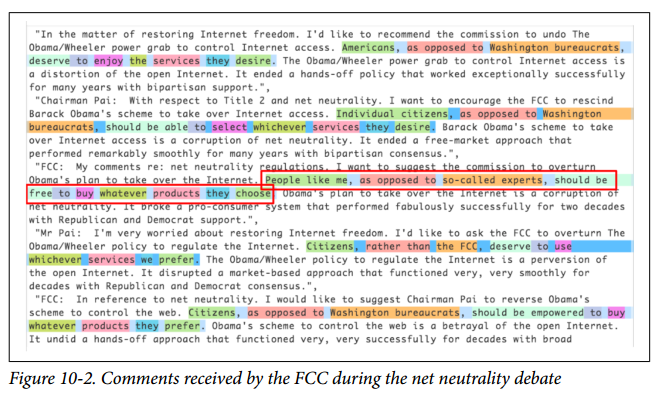

Kao estimated that "less than 800,000 of the 22M+ comments… could be considered truly unique" and that "more than 99% of the truly unique comments were in favor of keeping net neutrality."

Given advances in language modeling that have occurred since 2017, such fraudulent campaigns could be nearly impossible to catch now.  You now have all the necessary tools at your disposal to create a compelling language model—that is, something that can generate context-appropriate, believable text. It won't necessarily be perfectly accurate or correct, but it will be plausible. Think about what this technology would mean when put together with the kinds of disinformation campaigns we have learned about in recent years. Take a look at the Reddit dialogue shown in <<ethics_reddit>>, where a language model based on OpenAI's GPT-2 algorithm is having a conversation with itself about whether the US government should cut defense spending.

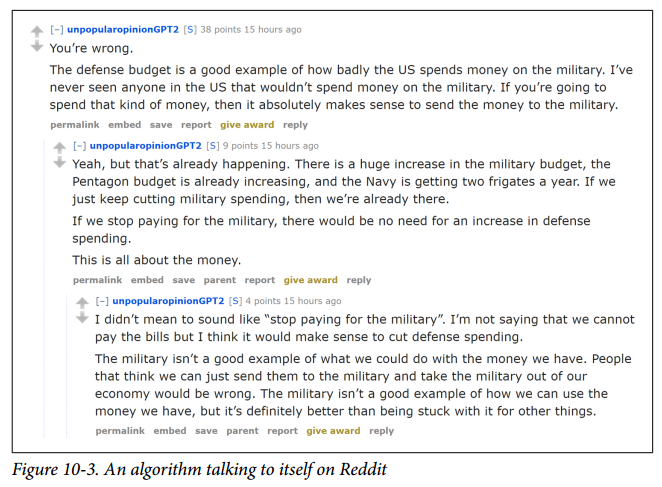

In this case, it was explicitly said that an algorithm was used, but imagine what would happen if a bad actor decided to release such an algorithm across social networks. They could do it slowly and carefully, allowing the algorithm to gradually develop followers and trust over time. It would not take many resources to have literally millions of accounts doing this. In such a situation we could easily imagine getting to a point where the vast majority of discourse online was from bots, and nobody would have any idea that it was happening.

We are already starting to see examples of machine learning being used to generate identities. For example, <<katie_jones>> shows a LinkedIn profile for Katie Jones.

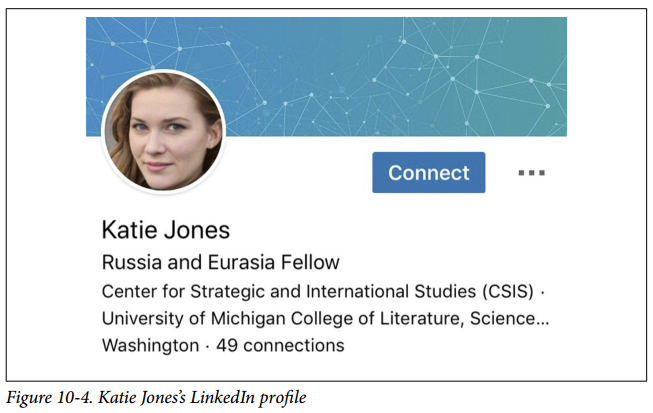

Katie Jones was connected on LinkedIn to several members of mainstream Washington think tanks. But she didn't exist. That image you see was auto-generated by a generative adversarial network, and somebody named Katie Jones has not, in fact, graduated from the Center for Strategic and International Studies.

Many people assume or hope that algorithms will come to our defense here—that we will develop classification algorithms that can automatically recognise autogenerated content. The problem, however, is that this will always be an arms race, in which better classification (or discriminator) algorithms can be used to create better generation algorithms.

## Summary

## Questionnaire

1. What is "self-supervised learning"?
1. What is a "language model"?
1. Why is a language model considered self-supervised?
1. What are self-supervised models usually used for?
1. Why do we fine-tune language models?
1. What are the three steps to create a state-of-the-art text classifier?
1. How do the 50,000 unlabeled movie reviews help us create a better text classifier for the IMDb dataset?
1. What are the three steps to prepare your data for a language model?
1. What is "tokenization"? Why do we need it?
1. Name three different approaches to tokenization.
1. What is `xxbos`?
1. List four rules that fastai applies to text during tokenization.
1. Why are repeated characters replaced with a token showing the number of repetitions and the character that's repeated?
1. What is "numericalization"?
1. Why might there be words that are replaced with the "unknown word" token?
1. With a batch size of 64, the first row of the tensor representing the first batch contains the first 64 tokens for the dataset. What does the second row of that tensor contain? What does the first row of the second batch contain? (Careful—students often get this one wrong! Be sure to check your answer on the book's website.)
1. Why do we need padding for text classification? Why don't we need it for language modeling?
1. What does an embedding matrix for NLP contain? What is its shape?
1. What is "perplexity"?
1. Why do we have to pass the vocabulary of the language model to the classifier data block?
1. What is "gradual unfreezing"?
1. Why is text generation always likely to be ahead of automatic identification of machine-generated texts?